# Estimating Eigenfunctions of the Transfer Operator

_Author_: [Pietro Novelli](https://pietronvll.github.io/)

This example is a reproduction of the second experiment of _"Sharp Spectral Rates for Koopman Operator Learning"_<cite data-footcite="Kostic2023SpectralRates">(Kostic et al. 2023)</cite>. We use `kooplearn` to approximate the leading eigenfunctions of the transfer operator of the overdamped Langevin dynamics
$$
X_{t + 1} = X_t -\frac{1}{\gamma}\nabla V(X_t)\Delta t + \frac{\sigma}{\gamma}\sqrt(\Delta t)\xi_t
$$
Here, $V$ is the potential function, $\gamma$ is a damping coefficient, and $\sigma$ is proportional to the temperature of the process: the higher the $\sigma$, the noisier is the dynamics. In this example we will study the so-called _Prinz Potential_<cite data-footcite="Prinz2011">(Prinz et al. 2011)</cite>:

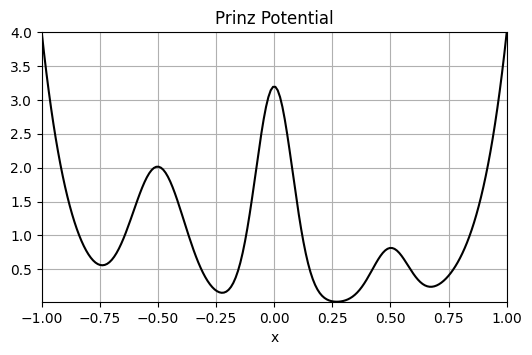

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [6., 3.5]

def prinz_potential(x):
    return 4 * (
        x**8
        + 0.8 * np.exp(-80 * (x**2))
        + 0.2 * np.exp(-80 * ((x - 0.5) ** 2))
        + 0.5 * np.exp(-40 * ((x + 0.5) ** 2))
    )

x = np.linspace(-1, 1, 200)
plt.plot(x, prinz_potential(x), 'k')
plt.margins(0)
plt.xlabel('x')
plt.title("Prinz Potential")
plt.grid()

`kooplearn` exposes the function [make_prinz_potential](../generated/kooplearn.datasets.make_prinz_potential.rst) to simulate the overdamped Langevin dynamics with this potential. 

In [2]:
from kooplearn.datasets import make_prinz_potential

gamma = 1.0
sigma = 2.0
data = make_prinz_potential(X0 = 0, n_steps=int(5e6), gamma=gamma, sigma=sigma)

for overdamped Langevin processes, the inverse temperature satisfies the relation $\beta = 2\gamma/\sigma^2$. With this, we can easily verify that `data` approximately samples the Boltzmann distribution $e^{-\beta V(x)}$.

Text(0.5, 0, 'x')

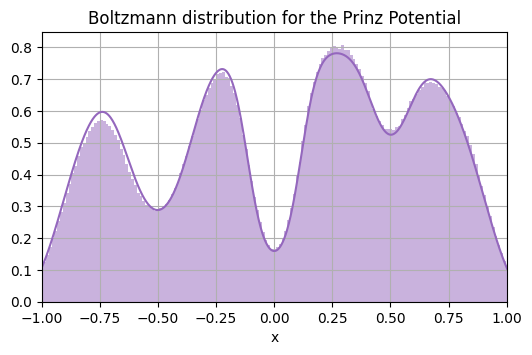

In [3]:
from scipy.integrate import romb

def compute_boltzmann_density(x, gamma, sigma):
    beta = 2*gamma/(sigma**2)
    pdf = np.exp(-beta*prinz_potential(x))
    total_mass = romb(pdf, dx=x[1] - x[0])
    return pdf/total_mass

x = np.linspace(-2, 2, 2048 + 1)
density = compute_boltzmann_density(x, gamma ,sigma)
plt.hist(data, bins=200, density=True, alpha=0.5, color="tab:purple");
plt.plot(x, density, color='tab:purple')
plt.xlim(-1, 1)
plt.grid()
plt.title("Boltzmann distribution for the Prinz Potential")
plt.xlabel("x")

### Estimating the eigenfunctions.
We will compare the _Reduced Rank Regression_ estimator <cite data-footcite="Kostic2022">(Kostic et al. 2022)</cite> against the classical _Principal Component_ estimator, also known as kernel DMD <cite data-footcite="Williams2015_KDMD">(Williams et al. 2015)</cite>. To this end, we use `kooplearn`'s [KernelRidge](../generated/kooplearn.kernel.KernelRidge.rst) class, with a simple Gaussian kernel (`rbf`).

In [4]:
from kooplearn.kernel import KernelRidge


def fit_and_estimate(reduced_rank, x, density):
    subsample = 100  # We need long trajectories to sample the Boltzmann distribution...
    gamma = 1.0
    sigma = 2.0
    data = make_prinz_potential(X0=0, n_steps=int(5e5), gamma=gamma, sigma=sigma)
    data = data.iloc[::subsample]  # ...but we don't need all the data to estimate the eigenfunctions
    model = KernelRidge(
        n_components=5, reduced_rank=reduced_rank, gamma=12.5, kernel="rbf", alpha=1e-6
    )  # Model definition
    model.fit(data)
    values, functions = model.eig(eval_right_on=x)  # Eigenvalue estimation
    sort_perm = np.flip(np.argsort(np.abs(values))) # Order eigenvalues decreasingly
    values, functions = values[sort_perm], functions[:, sort_perm]
    functions = normalize_eigenfunctions(functions, x, density)
    return functions


def normalize_eigenfunctions(functions, x, density):
    abs2_eigfun = (np.abs(functions) ** 2).T  # f(x)**2
    abs2_eigfun *= density  # Compute the norm with respect to the Boltzmann measure.
    dx = x[1] - x[0]
    funcs_norm = np.sqrt(romb(abs2_eigfun, dx=dx, axis=1))  # Norms
    functions *= funcs_norm**-1.0  # Normalize
    return functions

The code above is straightforward: the function `fit_and_estimate` samples a fresh new trajectory, fits a transfer operator model, computes its (right) eigenfunctions via `model.eig`, and evaluates it on the array `x` via the argument `eval_right_on=x`. Finally, it computes the normalization constant
$$\left(\int e^{-\beta V(x)} |\psi(x)|^2dx\right)^{1/2} $$
via the `normalize_eigenfunctions` helper method. We now run this function for both Reduced Rank (`reduced_rank = True`) and Principal Component (`reduced_rank = False`) estimators. To gather some statistics, we repeat the evaluation multiple times. 

In [5]:
from tqdm import tqdm
from collections import defaultdict
dt = 1e-4
n_repetitions = 10
results = defaultdict(list)
for method, reduced_rank in zip(["Principal Components (kDMD)", "Reduced Rank"], [False, True]):
    for _ in tqdm(range(n_repetitions)):
        results[method].append(fit_and_estimate(reduced_rank, x[:, None], density))

100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


let's print some results

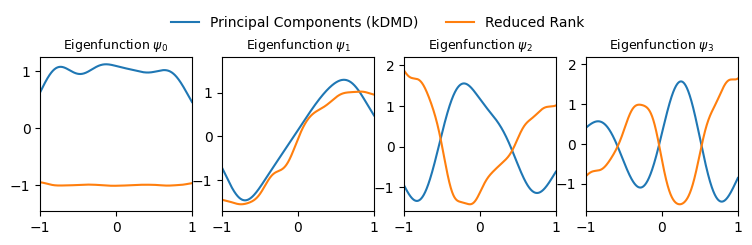

In [6]:
fig, axs = plt.subplots(ncols=4, figsize=(9, 2))
for fun_id, ax in enumerate(axs):
    for method, functions in results.items():
        color = "tab:blue" if "Principal" in method else "tab:orange"
        ax.plot(x, functions[0][:, fun_id], color=color, label=method)
    ax.set_title(f"Eigenfunction $\psi_{fun_id}$", fontsize=9)
    ax.set_xlim(-1, 1)
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncols=2,
    frameon=False,
    bbox_to_anchor=(0.0, 1.05, 1.0, 0.102),
)

As we can see, some eigenfunctions seem to have a sign mismatch. This is to be expected, as the spectral decomposition is [not unique](https://math.stackexchange.com/questions/1702730/sign-of-normalized-eigenvector-for-singular-value-decomposition), and multiplying by a constant scalar value (including -1), returns a valid eigenvector. To overcome this issue, we can write down a simple helper function to standardize them

In [7]:
def standardize_sign(eigenfunction, reference):
    norm_p = np.linalg.norm(eigenfunction + reference)
    norm_m = np.linalg.norm(eigenfunction - reference)
    if norm_p <= norm_m:
        return -1.0*eigenfunction
    else:
        return eigenfunction

`kooplearn` also exposes the function [compute_prinz_potential_eig](../generated/kooplearn.datasets.compute_prinz_potential_eig.rst) returning the exact eigenfunctions associated to the Prinz Potential dynamics. We will now use it to get the reference eigenfunctions, so that we can compare our estimators:

In [8]:
from kooplearn.datasets import compute_prinz_potential_eig

dt = data.attrs["params"]["dt"]
_, reference_eigfuns = compute_prinz_potential_eig(
    gamma, sigma, dt, eval_right_on=x, num_components=5
)
reference_eigfuns = normalize_eigenfunctions(reference_eigfuns, x, density)

we can finally plot everything together

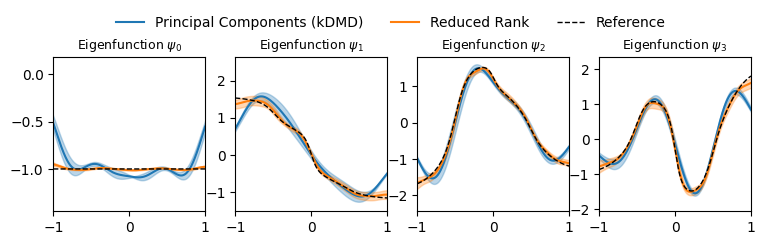

In [9]:
fig, axs = plt.subplots(ncols=4, figsize=(9, 2))
for fun_id, ax in enumerate(axs):
    for method, functions in results.items():
        # Standardize signs according to the reference
        functions = np.array(functions) # Convert list of arrays into array
        for i in range(n_repetitions):
            for j in range(functions.shape[-1]):
                functions[i, :, j] = standardize_sign(
                    functions[i, :, j], reference_eigfuns[:, j]
                )
        color = 'tab:blue' if 'Principal' in method else 'tab:orange' 
        m = functions.mean(0)[:, fun_id]
        st = functions.std(0)[:, fun_id]
        ax.plot(x, m, color=color, label=method)
        ax.fill_between(x, m - st, m + st, color=color, alpha=0.3)
    ax.plot(x, reference_eigfuns[:, fun_id], color='k', lw=1, ls='--', label='Reference')
    ax.set_title(f"Eigenfunction $\psi_{fun_id}$", fontsize=9)
    ax.set_xlim(-1, 1)
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncols=3,
    frameon=False,
    bbox_to_anchor=(0.0, 1.05, 1.0, 0.102),
)

...showing that the _Reduced Rank_ estimator approximates the reference eigenfunctions much better than the more common _Principal Component Regression_ (kernel DMD).